In [1]:
# 패키지 임포트

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [2]:
# mnist 데이터 다운로드

# root는 다운로드 위치, train이 true이면 train 아니면 test 데이터
# ToTensor로 변환을 해야지 모델이 학습하기 용이, download=True는 root 경로에 데이터셋이 없을 경우 인터넷에서 자동으로 다운로드
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

# DataLoader를 통해서 로드할 데이터셋 설정
# batch_size: 각 배치에 포함될 데이터 샘플 수 지정. 100의미: 100개의 이미지와 레이어블을 각 배치에 포함. 훈련시 한 번의 100개의 샘플 처리
# shuffle의 경우: 트레이닝의 경우 True로 설정하여 데이터 섞음.(=> 순서에 대한 의존성 줄이기). Test데이터는 섞지 않
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 146332549.31it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29266898.73it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45833994.28it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11245884.75it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [4]:
# 네트워크 정의

input_size = 784 # 28 * 28 픽셀의 이미지 평탄화
hidden_sizes = [128, 64] #2개의 은닉층
output_size = 10 #출력은 10개(0~9까지 구분)

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),#784개의 입력 특성받아서 128개 출력
                      nn.ReLU(), #비선형성을 도입하여 모델이 복잡한 패턴 학
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]), #128개의 입력을 받아 64개 출력
                      nn.ReLU(), # 2번째 Relu 함수
                      nn.Linear(hidden_sizes[1], output_size), #64개 입력받아 10개 출력
                      nn.LogSoftmax(dim=1)) #dim은 연산이 행이 아닌 열을 따라 수행
'''
미니배치 2개의 이미지가 있음 각 이미지에 대해 3개의(클래스)값을 출력
모델의 출력은 (2,3)
첫번쨰 차원은(2)는 배치 크기, 두번째 차원은(3) 클래스의 수 / (배치사이즈는 한 번에 네트워크를 통과시키는 데이터 샘플 )
[[log(p_cat_1), log(p_dog_1), log(p_bird_1)],
 [log(p_cat_2), log(p_dog_2), log(p_bird_2)]]
 durltj p_cat_1은 첫 번째 이미지가 고양이 클래스에 속할 확률, p_dog_2는 두번째 이미지가 개 클래스에 속할 확률

 LogSoftmax(dim=1)을 하면 두번째 차원(클래스 차원)을 따라 각 클래스에 대한 로그 확률을 정규화. 각 이미지(행)에 대해, 모든 클래스 확률의 합이 1

 ex)
 [log(p_cat_1), log(p_dog_1), log(p_bird_1)] = [-0.2, -1.5, -2.1]

 dim=0을 하게되면 배치 차원을 따라 연산을 수행함. 이는 의미가 없음.
 우리는 각 이미지가 독립적으로 각 클래스에 속할 확률을 계산하길 원함.

 텐서에서는 첫 번째 차원은 배치 차
'''

### Relu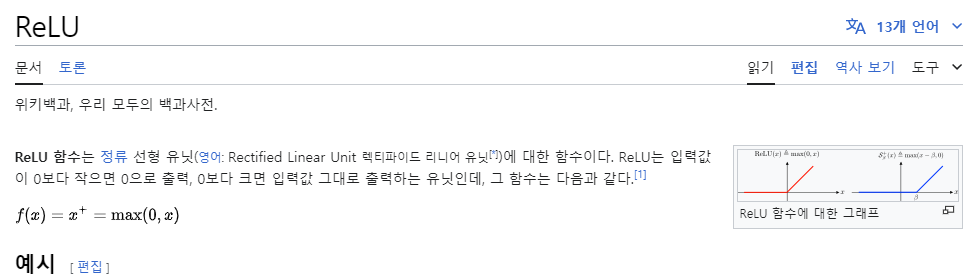

In [5]:
# 손실함수와 최적화

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.09)

In [6]:
# 훈련
epochs = 15
for e in range(epochs):
  running_loss = 0
  for images, labels in train_loader: # 배치 단위의 이미지와 레이블 로드
    images = images.view(images.shape[0], -1)

    optimizer.zero_grad() #optimizer 0으로 되돌리기 이전 역전파에 있던 gradient값이 남아있는 것을 방지하기 위

    #모델 계산
    output = model(images) #순전파

    #손실 계산
    loss = criterion(output, labels) #계산된 출력과 실제 레이블 간의 손실 계산

    #역전파
    loss.backward() #손실 함수의 그래디언트 계산

    #최적화
    optimizer.step() # 신경망의 가중치를 업데이트하는 단계 (최적화는 위에 sgd 사)

    running_loss += loss.item() #.item()은 tensor에 저장된 값만 가져옴
  else:
    print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))

Epoch 0 - Training loss: 0.6571257896473011
Epoch 1 - Training loss: 0.25922166587164003
Epoch 2 - Training loss: 0.1904377628552417
Epoch 3 - Training loss: 0.15048808420387408
Epoch 4 - Training loss: 0.12389741356174151
Epoch 5 - Training loss: 0.10442742926999926
Epoch 6 - Training loss: 0.0888943858180816
Epoch 7 - Training loss: 0.07796979697110752
Epoch 8 - Training loss: 0.0689276353875175
Epoch 9 - Training loss: 0.061443322100676594
Epoch 10 - Training loss: 0.0542723864208286
Epoch 11 - Training loss: 0.04830439921390886
Epoch 12 - Training loss: 0.043507184539921584
Epoch 13 - Training loss: 0.03886521293160816
Epoch 14 - Training loss: 0.03513630235218443


In [8]:
# 테스트
correct = 0
total = len(mnist_test)
with torch.no_grad(): # with torch.no_grad()는 해당 블록 내에서 수행되는 연산에 대해 그래디언트 계산을 비활성화
  # iterate through test set minibatchs
  for images, labels in tqdm(test_loader):
    # Forward pass
    # x = images.view(-1, 28, 28)
    x = images.view(images.shape[0], -1) #이미지를 1D 벡터로 평탄화하는 과정
    '''
    .view() 메서드는 주어진 크기로 텐서의 차원을 재구성.
    image_shape[0]은 배치사이즈, 배치 내의 이미지 개수 의미
    -1은 해당 차원의 크기를 나머지 요소들로부터 추론
    이를 통해서 images 텐서를 [배치크기, 나머지]의 모양으로 재구성
    ex)텐서의 초기모양 [배치크기, 3, 28, 28] => [배치크기, 784(3*28*28)]로 변환.
    이렇게 변환된 2차원 텐서는 신경망의 선형 레이어에 입력으로 사용될 수 있음
    '''
    y = model(x)

    predictions = torch.argmax(y, dim=1) #y값 제일 큰 확률 label
    correct += torch.sum((predictions == labels).float())

print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9793000221252441
